Após gerar o arquivo via Etapa1.cpp, basta colocar o arquivo estatisticas.json junto a pasta desse arquivo .ipynb.

OBS.: É necessário ajustar o nome do arquivo, para `estatistica` concatenado com `_` e em seguida o nome do grafo utilizado, por exemplo: `BHW1`. Ajustar na linha:

`nomeArquivo = 'estatisticas.json'`

para o nome do arquivo gerado na Etapa1.cpp

por exemplo:

`nomeArquivo = 'estatisticas_BHW1.json'`



=== Estatísticas do Grafo ===
                  Métrica                                         Valor
0                    nome                                          BHW1
1             numVertices                                            12
2              numArestas                                            11
3                numArcos                                            22
4   numVerticesRequeridos                                             7
5    numArestasRequeridas                                            11
6      numArcosRequeridos                                            11
7               densidade                                      0.333333
8             componentes                                             1
9                 grauMin                                             4
10                grauMax                                            10
11           caminhoMedio                                       16.7121
12               diametro         

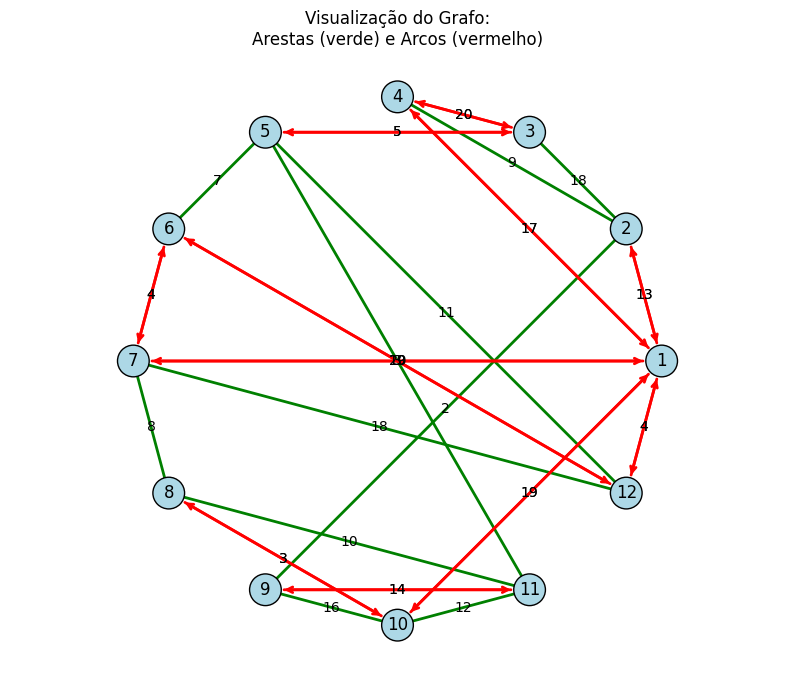

In [25]:
import json
import re
import math
import matplotlib.pyplot as plt
import pandas as pd

# Nome do arquivo com os dados (JSON)
nome_arquivo = 'estatisticas_BHW1.json'

# Carrega os dados do arquivo JSON
with open(nome_arquivo, 'r') as arquivo:
    dados = json.load(arquivo)

# Exibe as estatísticas utilizando pandas.
estatisticas = dados["estatisticas"]
df_estatisticas = pd.DataFrame(list(estatisticas.items()), columns=["Métrica", "Valor"])
print("=== Estatísticas do Grafo ===")
print(df_estatisticas)

# A chave "grafo_json" contém uma string com um JSON
grafo_json_str = dados["grafo_json"]
# Converte a string para um dicionário
grafo = json.loads(grafo_json_str)

# Extrai as listas de vértices, arestas (não direcionadas) e arcos (direcionados)
vertices = grafo.get("vertices", [])
arestas = grafo.get("arestas", [])
arcos = grafo.get("arcos", [])

# --- Geração do conjunto total de IDs ---
# Inclui os vértices definidos explicitamente e aqueles referenciados em arestas e arcos.
todos_ids = set()
for v in vertices:
    todos_ids.add(v["id"])

for edge in arestas:
    todos_ids.add(edge["origem"])
    todos_ids.add(edge["destino"])

for arc in arcos:
    todos_ids.add(arc["origem"])
    todos_ids.add(arc["destino"])

# Para exibição: caso algum vértice não tenha label (porque não estava na lista original),
# usamos o próprio id como label.
# Cria uma lista de dicionários para os vértices completos
todos_vertices = []
for vid in sorted(todos_ids):
    # Procura se o vértice já está definido em 'vertices'
    label = next((v["id"] for v in vertices if v["id"] == vid), vid)
    todos_vertices.append({"id": vid, "label": label})

# Exibe os vértices completos em DataFrame.
df_vertices = pd.DataFrame(todos_vertices)
print("\n=== Vértices ===")
print(df_vertices)

# Exibe as arestas e arcos em DataFrames.
df_arestas = pd.DataFrame(arestas)
df_arcos = pd.DataFrame(arcos)

print("\n=== Arestas (não direcionadas) ===")
print(df_arestas)
print("\n=== Arcos (direcionados) ===")
print(df_arcos)

# --- Processamento e visualização do grafo ---

# Calcula a posição dos vértices utilizando um layout circular.
num_vertices = len(todos_ids)
raio_layout = 5  # Tamanho da circunferência para distribuição dos nós.
positions = {}
# Ordena os vértices para garantir posicionamento consistente
todos_ids_ordenados = sorted(todos_ids)
for i, vid in enumerate(todos_ids_ordenados):
    angle = 2 * math.pi * i / num_vertices
    x = raio_layout * math.cos(angle)
    y = raio_layout * math.sin(angle)
    positions[vid] = (x, y)

# Configuração do plot.
plt.figure(figsize=(10, 8))
ax = plt.gca()
node_radius = 0.3  # Raio dos círculos que representam os nós.

# Desenha os vértices.
for vid in todos_ids_ordenados:
    x, y = positions[vid]
    circle = plt.Circle((x, y), node_radius, color="lightblue", ec="black", zorder=2)
    ax.add_patch(circle)
    plt.text(x, y, str(vid), fontsize=12, ha="center", va="center", zorder=3)

# Função para ajustar as coordenadas, de forma que as linhas não partam do centro dos nós.
def offset_coords(x1, y1, x2, y2, offset):
    dx = x2 - x1
    dy = y2 - y1
    dist = math.sqrt(dx**2 + dy**2)
    if dist == 0:
        return (x1, y1, x2, y2)
    dx_norm = dx / dist
    dy_norm = dy / dist
    return (x1 + dx_norm * offset, y1 + dy_norm * offset,
            x2 - dx_norm * offset, y2 - dy_norm * offset)

# Desenha as arestas (não direcionadas) em verde.
for edge in arestas:
    origem = edge["origem"]
    destino = edge["destino"]
    custo = edge["custoTransito"]
    x1, y1 = positions[origem]
    x2, y2 = positions[destino]
    new_x1, new_y1, new_x2, new_y2 = offset_coords(x1, y1, x2, y2, node_radius)
    plt.plot([new_x1, new_x2], [new_y1, new_y2], color="green", linewidth=2, zorder=1)
    # Posiciona o rótulo da aresta no meio da conexão.
    mid_x = (new_x1 + new_x2) / 2
    mid_y = (new_y1 + new_y2) / 2
    plt.text(mid_x, mid_y, str(custo), fontsize=10, color="black", ha="center", va="center", zorder=3)

# Desenha os arcos (direcionados) em vermelho.
for arc in arcos:
    origem = arc["origem"]
    destino = arc["destino"]
    custo = arc["custoTransito"]
    x1, y1 = positions[origem]
    x2, y2 = positions[destino]
    new_x1, new_y1, new_x2, new_y2 = offset_coords(x1, y1, x2, y2, node_radius)
    ax.annotate("",
                xy=(new_x2, new_y2), xycoords="data",
                xytext=(new_x1, new_y1), textcoords="data",
                arrowprops=dict(arrowstyle="->", color="red", lw=2),
                zorder=1)
    # Posiciona o rótulo do arco.
    mid_x = (new_x1 + new_x2) / 2
    mid_y = (new_y1 + new_y2) / 2
    plt.text(mid_x, mid_y, str(custo), fontsize=10, color="black", ha="center", va="center", zorder=3)

plt.title("Visualização do Grafo:\nArestas (verde) e Arcos (vermelho)")
plt.axis("equal")
plt.axis("off")
plt.show()
